In [2]:
import json
import pandas as pd
import matplotlib.pyplot as plt

# import file
with open("./data/tomato_cropping_data.json", "r", encoding="utf-8") as f:
    raw_data = json.load(f)

# Expanding userId + croppingData inside field to one row
records = []
for farm in raw_data:
    user_id = farm.get("userId")
    for crop in farm.get("croppingData", []):
        record = {
            "userId": user_id,
            **crop  # bring crop dict keys
        }
        records.append(record)

df = pd.DataFrame(records)




In [3]:
# import file
with open("./data/tomato_env_data.json", "r", encoding="utf-8") as f:
    raw_data = json.load(f)

### 577개 토마토 농가 (2016~2024) metadata

In [4]:
df.dtypes

userId                   object
statusCode               object
statusMessage            object
croppingSerlNo          float64
croppingSeasonName       object
itemCode                 object
croppingDate             object
croppingEndDate          object
croppingSystem           object
cultivationArea         float64
calCultivationArea      float64
plantNum                float64
calPlantNum             float64
stemSlabNum             float64
planSlabNum             float64
plantDensity            float64
standardPlantDensity    float64
floodlightDec           float64
leafArea                float64
stndTemp                float64
stndWeight              float64
stndSolar               float64
stndMeta                float64
dtype: object

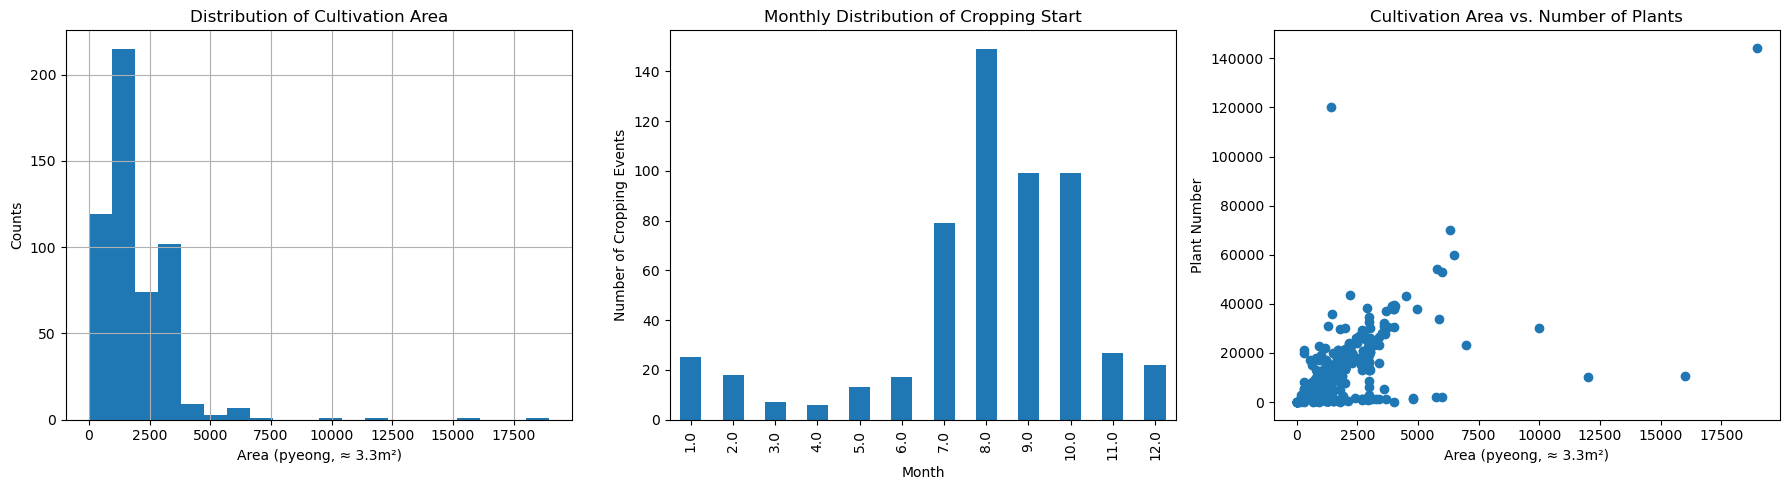

In [5]:
df["croppingDate"] = pd.to_datetime(df["croppingDate"], errors="coerce")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Cultivation Area Histogram
df["cultivationArea"].hist(bins=20, ax=axes[0])
axes[0].set_title("Distribution of Cultivation Area")
axes[0].set_xlabel("Area (pyeong, ≈ 3.3m²)")
axes[0].set_ylabel("Counts")

# 2. Cropping Start Month
df["croppingDate"].dt.month.value_counts().sort_index().plot(kind="bar", ax=axes[1])
axes[1].set_title("Monthly Distribution of Cropping Start")
axes[1].set_xlabel("Month")
axes[1].set_ylabel("Number of Cropping Events")

# 3. Area vs. Plant Number
axes[2].scatter(df["cultivationArea"], df["plantNum"])
axes[2].set_title("Cultivation Area vs. Number of Plants")
axes[2].set_xlabel("Area (pyeong, ≈ 3.3m²)")
axes[2].set_ylabel("Plant Number")

plt.tight_layout()
plt.show()

### 생육데이터 확인 (tomato_cultivate_data_valid)

In [4]:
# PF_0020745_01
import json
import pandas as pd

with open("./data/tomato_cultivate_data_valid.json", "r", encoding="utf-8") as f:
    raw_data = json.load(f)

# 평탄화
records = []
for entry in raw_data:
    user_id = entry.get("userId")
    serl_no = entry.get("croppingSerlNo")
    for row in entry.get("cultivateData", []):
        if row.get("statusCode") in [None, "00"]:
            record = {
                "userId": user_id,
                "croppingSerlNo": serl_no,
                **row
            }
            records.append(record)


# 데이터프레임 변환
df = pd.DataFrame(records)
df["measDate"] = pd.to_datetime(df["measDate"])
df["week"] = df["measDate"].dt.isocalendar().week
df["year"] = df["measDate"].dt.isocalendar().year


In [5]:
count = df[df["userId"] == "PF_0020745"].shape[0]
print(f"✅ PF_0020745 has {count} valid growth records.")

✅ PF_0020745 has 213 valid growth records.


In [6]:
## measdata per growers

# userId별 측정 데이터 수 집계
obs_counts = df.groupby("userId")["measDate"].count().reset_index()
obs_counts.columns = ["userId", "num_records"]

# 평균, 최솟값, 최댓값 출력
mean_count = obs_counts["num_records"].mean()
min_count = obs_counts["num_records"].min()
max_count = obs_counts["num_records"].max()

print(f"📊 평균 생육 데이터 수 (농가 기준): {mean_count:.2f}")
print(f"🔍 최소: {min_count}, 최대: {max_count}")


📊 평균 생육 데이터 수 (농가 기준): 142.13
🔍 최소: 4, 최대: 520


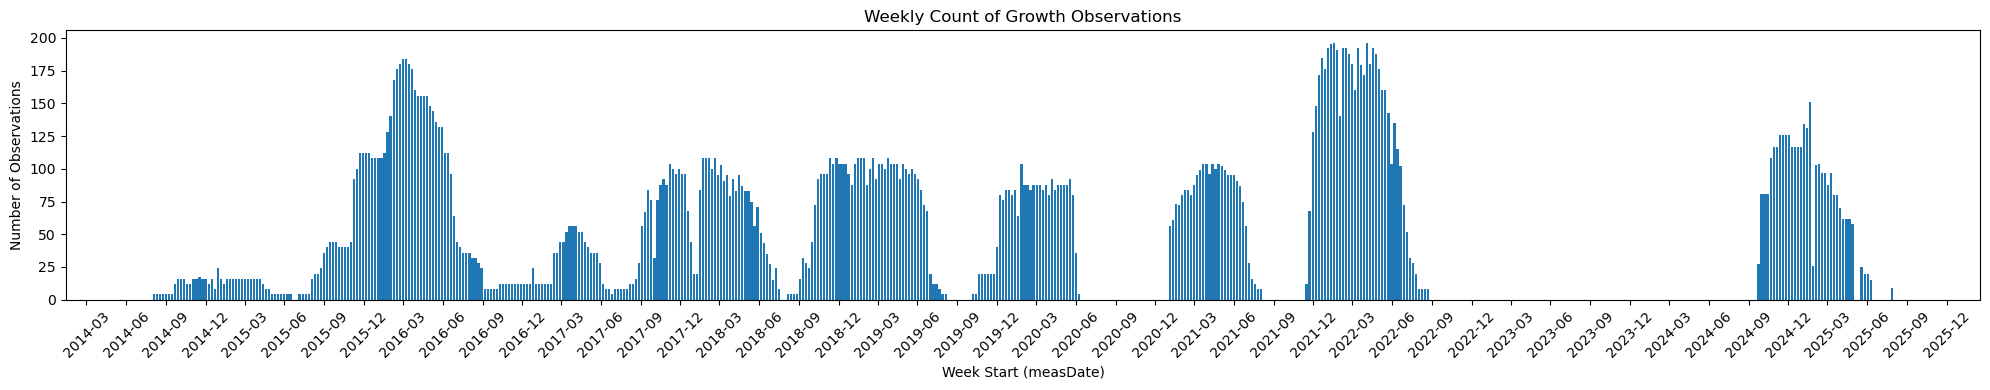

In [7]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

df["week_start"] = df["measDate"].dt.to_period("W").apply(lambda r: r.start_time)
weekly_counts = df.groupby("week_start").size().reset_index(name="count")
plt.figure(figsize=(20, 4))
plt.bar(weekly_counts["week_start"], weekly_counts["count"], width=5)

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.title("Weekly Count of Growth Observations")
plt.xlabel("Week Start (measDate)")
plt.ylabel("Number of Observations")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [15]:
pivot = df.groupby(["userId"])
pivot

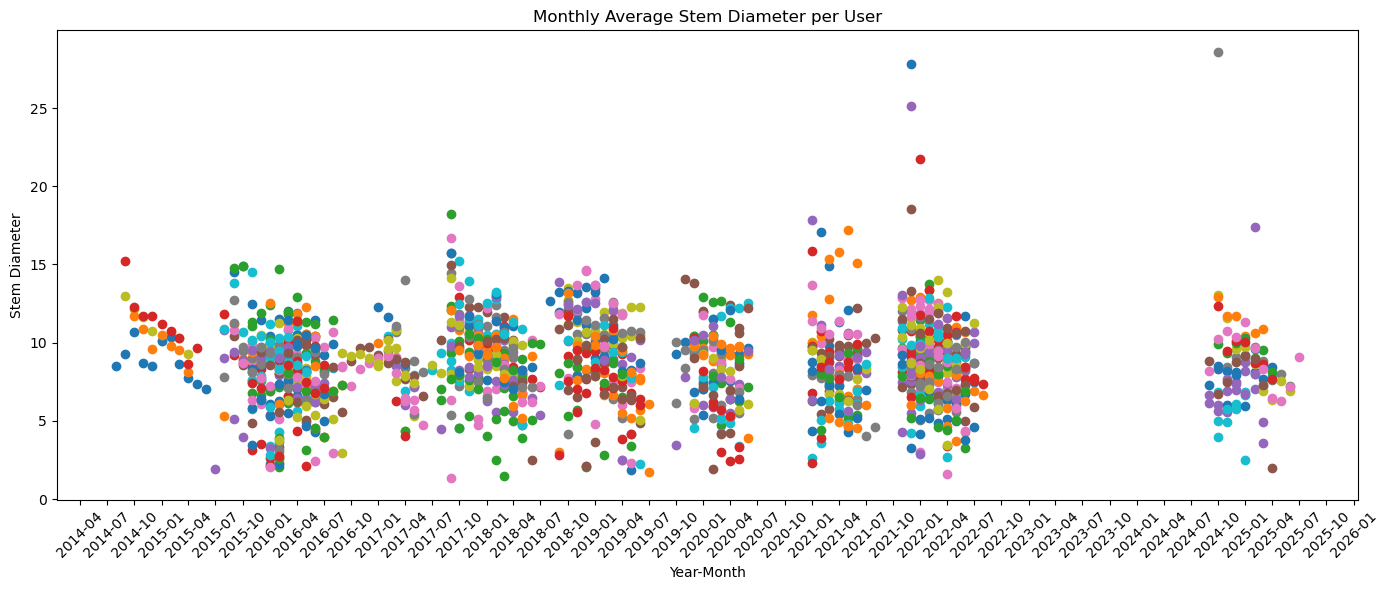

In [9]:
df = df.dropna(subset=["stemDiameter", "measDate"])
df["year_month"] = df["measDate"].dt.to_period("M").astype(str)

pivot = df.groupby(["userId", "year_month"])["stemDiameter"].mean().reset_index()
pivot = pivot[(pivot["stemDiameter"] >= 1) & (pivot["stemDiameter"] <= 30)] # 1~30 mm 로 토마토 직경 최대 길이 제한 설정
pivot["year_month_dt"] = pd.to_datetime(pivot["year_month"], format="%Y-%m")

plt.figure(figsize=(14, 6))
for user_id in pivot["userId"].unique():
    subset = pivot[pivot["userId"] == user_id]
    plt.scatter(subset["year_month_dt"], subset["stemDiameter"], label=user_id)

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.title("Monthly Average Stem Diameter per User")
plt.xlabel("Year-Month")
plt.ylabel("Stem Diameter")
plt.xticks(rotation=45)
#plt.legend(title="User ID", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

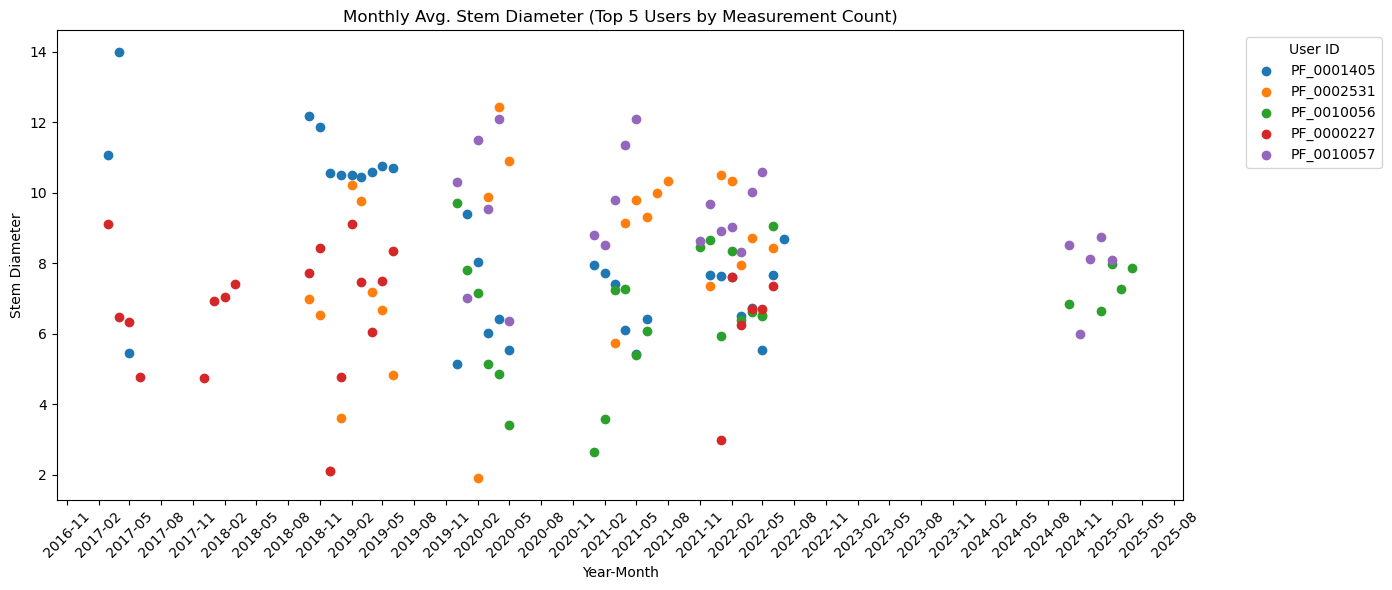

In [ ]:
top_users = (
    pivot["userId"]
    .value_counts()
    .head(5)
    .index
    .tolist()
) # 측정수 상위 5개 농가 줄기 직경 변화

plt.figure(figsize=(14, 6))

for user_id in top_users:
    subset = pivot[pivot["userId"] == user_id]
    plt.scatter(subset["year_month_dt"], subset["stemDiameter"], label=user_id)

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.title("Monthly Avg. Stem Diameter (Top 5 Users by Measurement Count)")
plt.xlabel("Year-Month")
plt.ylabel("Stem Diameter")
plt.xticks(rotation=45)
plt.legend(title="User ID", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()